**Single Cell Resolution Analysis of Ca Imaging Data for Hydra v4** 
=============================================================
*(Use with data from tdTomato_GCamP Animals)*

Requires:
-------------------------
- Green and Red Channel Videos From 2-Colour Confocal (GCaMP Channel and tdTomato)
- Tracking Position Information From ICY Spot Tracking Protocol (Exported as CSV)
- Conda Environment: Caiman_NOAH3
- SCHyA .py file

INPUT PATHS
-----------------
Enter paths to the appropriate files                    
**Videos must be .avi (convert in imageJ if not)**     
**Can also use a Tif sequence folder - change the read data function to Read_Data_TIFseq for this**    
**If using windows**: Paths must start with an 'r' character: e.g. vid_path = **r**"C:\Users\rylab\ path to your file \clip.avi"

In [ ]:
# #input path to your .csv from ICY
# csv_path = '/Users/noah/Documents/Columbia_Project/thesis_dump/VID1_oct_4_3hz/AVIs_and_CSV/points.csv'

# #input path to .avi of GCaMP Video
# vid_path = '/Users/noah/Documents/Columbia_Project/thesis_dump/VID1_oct_4_3hz/AVIs_and_CSV/green(1-852).avi'

# #input path to .avi of tdTomato Video
# red_vid_path = '/Users/noah/Documents/Columbia_Project/thesis_dump/VID1_oct_4_3hz/AVIs_and_CSV/red(1-852).avi'


SET UP DATA  
-----------------------
Run the following cells to set up the 
data to be analysed        
**Set the FFmpeg path before running this cell**

In [ ]:
#importing packages

import SCHyA as hy
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
import seaborn as sns

#dependancies from old script:
from collections import defaultdict
import math

In [ ]:
#new funcs to load new data:

def load_intensities(start_idx_path: str, intensity_path: str, channel: str) -> pd.DataFrame:
    """ Loads in a raw intensity .csv file and generates a dataframe for it.

        Arguments:
            -start_idx_path [str]: path to the .csv file containing the starting index of
                                    every track, exported from Icy, for a given channel (red or green)
            - intensity_path [str]: path to the .csv file containing the intensity output,
                                    exported from Icy, for a given channel (red or green)
            - channel [str]: desired channel intensity to extract (red or green)
        Returns:
            - intensities_df [Pandas]: dataframe containing mean intensities over all tracks
                                        for the specified channel
    """

    assert(channel in ['red', 'green']), \
    "Please provide a valid channel color (\'red\' or \'green\')"

    # load the starting index file
    start_idx_df = pd.read_csv(start_idx_path, names=['start_idx'])
    start_idxs = list(start_idx_df['start_idx'])
    track_ranges = [(start, stop) for start, stop in zip(start_idxs[:-1], start_idxs[1:])]
   
    # load raw intensities
    raw_df = pd.read_csv(intensity_path, names=["Frame", "Mean", "Min", "Max", "Variance", "Median"])
    raw_df.drop(columns=['Min', 'Max', 'Variance', 'Median'], inplace=True)

    intensities = defaultdict(list)
    for track_num, tup in enumerate(track_ranges):
        start = int(tup[0])
        end = int(tup[1])

        # extract the corresponding intensity and save to dictionary with correct track number
        intensity = list(raw_df.iloc[start:end]['Mean'])
        intensities[f'Track #{track_num}'].append(intensity)

        # if we reach the very last start index
        if tup[1] == track_ranges[-1][1]:
            # manually insert the very last track
            start = track_ranges[-1][1]
            end = len(raw_df)-1
            intensity = list(raw_df.iloc[start:end]['Mean'])
            intensities[f'Track #{track_num + 1}'].append(intensity)
        
    # generate dataframe
    intensities_df = pd.DataFrame(dict([(k, pd.Series(v[0])) for k,v in intensities.items()]))

    # replace NaN values in red channel with 0.0
    # if channel == 'red':
    #   intensities_df = intensities_df.replace(np.nan, 0.0)


    return intensities_df



def get_channel_links(links_path, red_df, green_df):
  """ Loads the .xml file for linking tracks between the red and green channels
      and isolates the signal to where it is present in the green and prunes the
      two channels respectively.

      Arguments:
        - links_path [str]: path to the .xml file contraining the matching between
                            tracks in the red and green channels
        - red_df [Pandas]: dataframe for the red channel
        - green_df [Pandas]: dataframe for the green channel (processed to impute
                             missing detections)
      Returns:
        - pruned_links [dict]: mapping of green channel track numbers to tuple containing
                               the pruned intensities for the red and green channels
  """

  links_df = pd.read_excel(links_path)
  links = dict()

  for row in links_df.itertuples():
    # only consider entries for which there is a matching green intensity
    if not math.isnan(row[2]):
      red_track = int(row[1])
      green_track = int(row[2])
    
      try:
        red_intensity = list(red_df[f'Track #{red_track}'])
        green_intensity = list(green_df[f'Track #{green_track}'])
      except:
        if f'Track #{red_track}' not in red_df.keys() and f'Track #{green_track}' not in green_df.keys():
          print('Tracks not found in either channel!')
        if f'Track #{red_track}' not in red_df.keys():
          print(f"Track {red_track} not in red!")
        elif f'Track #{green_track}' not in green_df.keys():
          print(f"Track {green_track} not in green!")

      # save the link indexed by the green track number
      links[green_track] = (red_intensity, green_intensity)

  pruned_links = dict()
  # eliminate red signal frames with no green signal
  for green_track, intensities in links.items():
    r, g = intensities
    # find frames where green signal is missing
    no_green = [i for sublist in np.argwhere(np.isnan(g)) for i in sublist]
    # remove these frames from both channels

    #this absolutely will not work!!! removes differing number of frames from each neuron & eliminates correlation between time and frame number!!!!!
    # g_pruned = [j for i, j in enumerate(g) if i not in no_green]
    # r_pruned = [j for i, j in enumerate(r) if i not in no_green]

    #-------------------------------  NEW NAN HANDLER --------------------------------------------------------------

    #sets nan values to 0 in green values - can do this faster and cleaner in numpy but testing this out first since none of this data is in array form (yet)

    g_pruned = [green_val if not np.isnan(green_val) else (np.nanmean(g) + 5*np.random.random_sample()) for green_val in g]
    r_pruned = [red_val if not np.isnan(red_val) else (np.nanmean(r) + 15*np.random.random_sample()) for red_val in r]
  

    # save to new dictionary
    pruned_links[green_track] = (r_pruned, g_pruned)

  return pruned_links


def query_track(links, channel, green_track):
  """ Returns the intensity for either a red or green channel.

      Arguments:
        - links [dict]: mapping of green track number to (red, green) tuple
                        containing intensities for the matching red and green channels
        - channel [str]: desired channel intensity to extract (red or green)
        - green_track [int]: green track number key used to extract the intensities
                           tuple
      Returns:
        - channel_intensity [list]: processed intensity for the desired channel
  """

  assert(channel in ['red', 'green']), \
    "Please provide a valid channel color (\'red\' or \'green\')"

  if channel == 'red':
    channel_intensity = links[green_track][0]
  elif channel == 'green':
    channel_intensity  = links[green_track][1]
    
  return channel_intensity


In [ ]:
#paths

red_start_idx = r'C:\Users\rylab\Documents\NoahT2022\Data\SingleCell_Tracking\SingleCellTracking_From_ALI_30_8_2022\6X_2BIN_TINY_tdT_INTENSITY.csv_trackStartIndex.txt'
green_start_idx = r'C:\Users\rylab\Documents\NoahT2022\Data\SingleCell_Tracking\SingleCellTracking_From_ALI_30_8_2022\6X_2BIN_TINY_G7_INTENSITY_NEW.csv_trackStartIndex.txt'

red_raw_path = r'C:\Users\rylab\Documents\NoahT2022\Data\SingleCell_Tracking\SingleCellTracking_From_ALI_30_8_2022\6X_2BIN_TINY_tdT_INTENSITY.csv.txt'
green_raw_path = r'C:\Users\rylab\Documents\NoahT2022\Data\SingleCell_Tracking\SingleCellTracking_From_ALI_30_8_2022\6X_2BIN_TINY_G7_INTENSITY_NEW.csv.txt'


In [ ]:
red = load_intensities(red_start_idx, red_raw_path, 'red')
green = load_intensities(green_start_idx, green_raw_path, 'green')

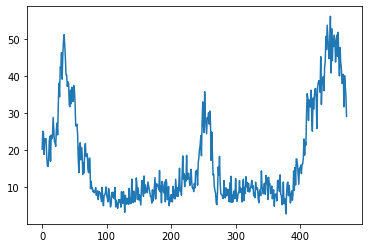

In [ ]:
#each track is an individual neuron (seemingly, from inspecting the data)
coldata = green['Track #450']

plt.plot(coldata)
plt.show()

In [28]:
#using linked paths info - seems like a messy way to handle this, should also be a .csv instead of .xls
links_path = r'C:\Users\rylab\Documents\NoahT2022\Data\SingleCell_Tracking\SingleCellTracking_From_ALI_30_8_2022\linked_tracks.xls'

#dict of linked channels
links = get_channel_links(links_path, red, green)

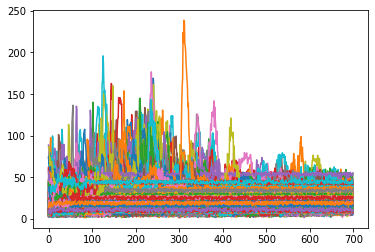

In [29]:
for i in range(len(links)):
    plt.plot(links[i][1])
plt.show()

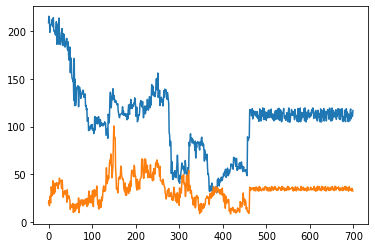

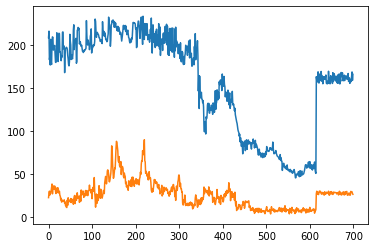

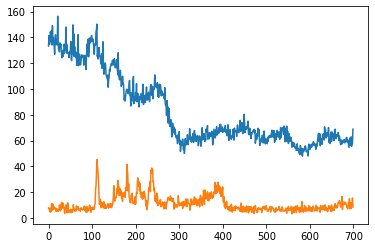

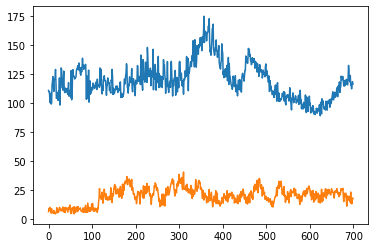

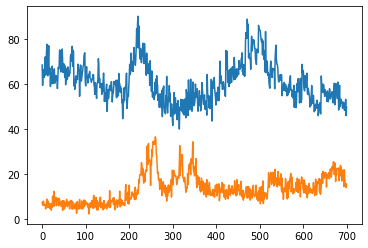

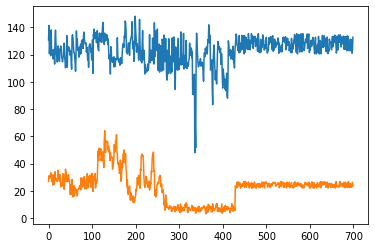

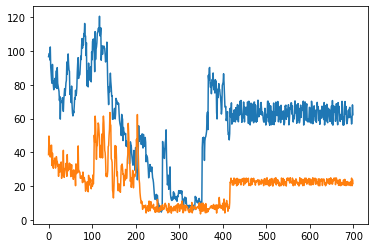

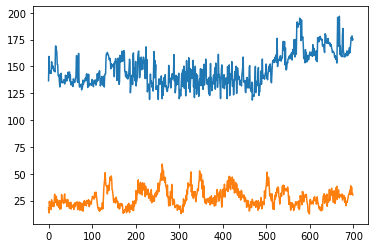

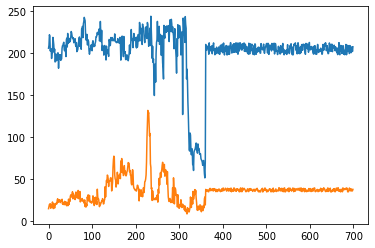

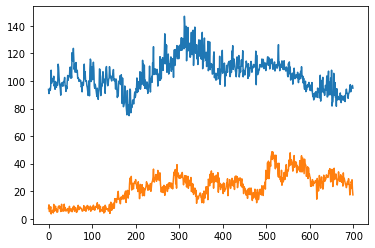

In [30]:
for i in range(0,10):
    plt.plot(links[i][0])
    plt.plot(links[i][1])
    plt.show()

In [31]:
#tracks are all different lengths? this seems to be a problem nan handling may have broken this
green_intensities = np.array([np.array(links[i][1]) for i in range(len(links)) if links])
red_intensities = np.array([np.array(links[i][0]) for i in range(len(links))])

# print(green_intensities[30].shape)
# nanlocs = np.isnan(green_intensities)
# print(nanlocs)


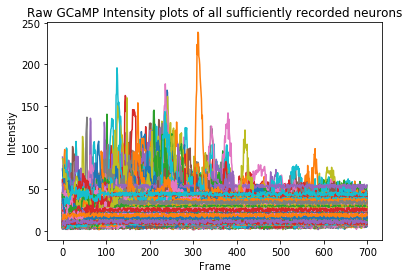

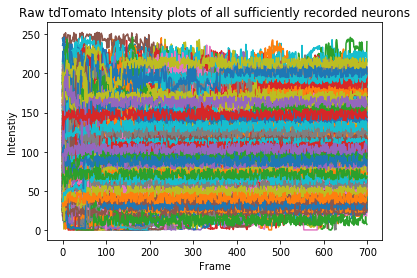

In [32]:
for track in green_intensities:
    plt.plot(track)
    plt.title('Raw GCaMP Intensity plots of all sufficiently recorded neurons')
    plt.xlabel('Frame')
    plt.ylabel('Intenstiy')
plt.show()

for track in red_intensities:
    plt.plot(track)
    plt.title('Raw tdTomato Intensity plots of all sufficiently recorded neurons')
    plt.xlabel('Frame')
    plt.ylabel('Intenstiy')
plt.show()

In [33]:
normdat_green = np.asanyarray(green_intensities)
normdat_red = np.asanyarray(green_intensities)

In [34]:
greenpad = [np.pad(green, (0,(700-len(green))), mode = 'edge' ) for green in normdat_green]

redpad = [np.pad(red, (0,(700-len(red))), mode = 'edge' ) for red in normdat_red]


# for i in range(len(greenpad)):
#     print(len(greenpad[i]))
#     print(len(redpad[i]))



In [35]:
# check for nan vals
sum=0
for reds in redpad:
    stDev = np.std(reds)
    sum += (np.isnan(reds).any())
print(sum, stDev)

0 1.5041807516687142


C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encoun

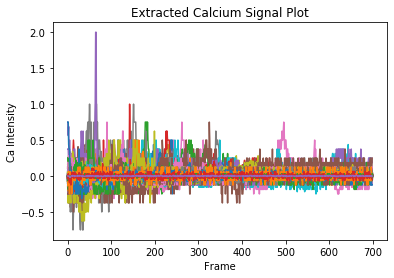

In [36]:
CaSignal = hy.ICAdecorr(greenpad, redpad, 2, 1)

#Plot Signal
for i in range(len(CaSignal)):
    plt.plot(CaSignal[i])
plt.title('Extracted Calcium Signal Plot')
plt.xlabel('Frame')
plt.ylabel('Ca Intensity')
plt.show()

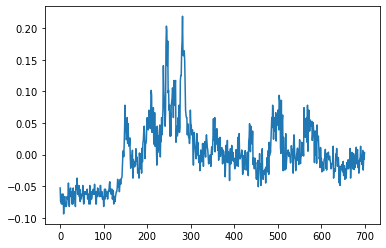

In [37]:
plt.plot(CaSignal[75])

In [38]:
#reading in data
# positions, vid, red_vid = hy.Read_Data(csv_path, vid_path, red_vid_path)

In [39]:
# reshape the .csv into a more useable form
# posit = hy.reshaper(positions)

In [40]:
# #Get Information About Raw Data
# num_frames = len(vid)
# num_red_frames = len(red_vid)
# num_tracks = int(positions[len(positions)-1,0])
# #Display Information
# print('Numer of Frames in Green Video:', num_frames)
# print('Number of Frames in Red Video:', num_red_frames)
# print('Number of Points Tracked by ICY:', num_tracks)

CALCIUM SIGNAL EXTRACTION
------------------------
These following cells will remove neurons that were not completely tracked throughout the video, extract a region of interest around each fully tracked neuron, and extract the intensity of each neuron throughout the video and plot the raw intensities. The signal can then be corrected for motion artefacts by finding the ratiometric signal between the green and red channels - dR/R; or through the use of Independant Component Analysis. 

In [41]:
#Discard Neurons which were incompletely tracked
# posit_corrected = hy.remove_incomplete_tracks(posit, num_frames)

The Following 2 Cells may Give a Runtime Warning - This is Fine

**Must Run the Extract_Fluorescence function before the SingleCellIntensities function as you need to use the updated 'posit_corrected' output from Extract_Fluorescence as SingleCellIntensities as no feature to correct this itself**

In [42]:
#Extract the fluorescence intensity in the GCaMP channel throughout the video for each neuron

# #size of ROI
# dim = 9
# subROI_Circle_size = 4
# LookBack = 4 #resistance of tracking to movement i.e. how quickly a tracked neuron can move before position resets

# #Extract large ROI and remove points too close to edge
# intensities1, posit_corrected1 = hy.Extract_Fluorescence(posit_corrected, vid, dimention = dim)

# #extract signal from subROI around neuron
# intensities1, posit_corrected1, neuron_pts = hy.SingleCellIntensities(vid, posit_corrected1, dim, subROI_Circle_size, LookBack)

In [43]:
#Extract the fluorescence intensity in the Red channel throughout the video for each neuron

# intensities_red, posit_corrected1 = hy.Extract_Fluorescence(posit_corrected1, red_vid, dim)

number of neurons =  595


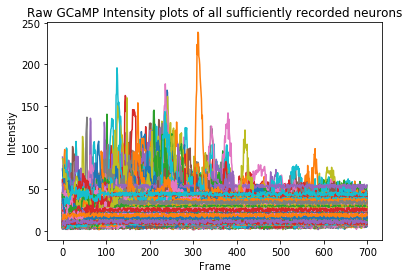

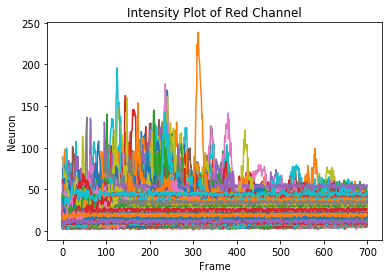

In [44]:
#plot raw neuronal intensities & display number of fully tracked neurons
intensities1 = greenpad
intensities_red = redpad
number_of_neurons = len(intensities1)
print('number of neurons = ', number_of_neurons)

for track in range(len(intensities1)):
    plt.plot(intensities1[track])
    plt.title('Raw GCaMP Intensity plots of all sufficiently recorded neurons')
    plt.xlabel('Frame')
    plt.ylabel('Intenstiy')
plt.show()

#Plot intensities of red channels - used to identify motion artefacts and leaking between channels
for track in range(len(intensities1)):
    plt.plot(intensities_red[track])
    plt.title('Intensity Plot of Red Channel')
    plt.xlabel('Frame')
    plt.ylabel('Neuron')

C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\rylab\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encoun

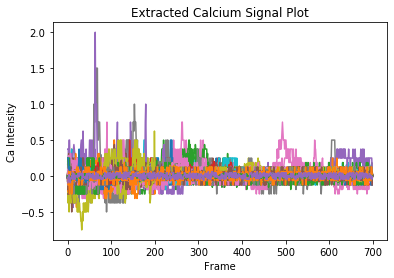

In [45]:
#DeltaR/R or ICA used to correct for motion artefacts and cross channel leaking
#Obtain Artefact Free Ca Signal
CaSignal = hy.ICAdecorr(intensities1, intensities_red, 2, 2)

#Plot Signal
for i in range(len(CaSignal)):
    plt.plot(CaSignal[i])
plt.title('Extracted Calcium Signal Plot')
plt.xlabel('Frame')
plt.ylabel('Ca Intensity')
plt.show()

In [46]:
# remove nematocytes
import scipy as sp 

def Gaussian_noise_filter2(intensities, alpha):
    new_data = []
    filtered_tracks = []
    for i in range(len(intensities)):
        a,b = sp.stats.normaltest(intensities[i])
        if b >= alpha:
            #follows normal dist
            filtered_tracks.append(intensities[i])
        elif b < alpha:
            #does not follow normal dist
            new_data.append(intensities[i])
    return new_data, filtered_tracks


#detrend before filtering nematocytes - it wont work otherwise because of maths:
detrended_data = hy.detrend_all(intensities1, 17)

#NOTE: need to go back and adjust for the removed neurons in the red channel as now the linking is broken
filt_neurons, nematocytes = Gaussian_noise_filter2(detrended_data, 0.0001)


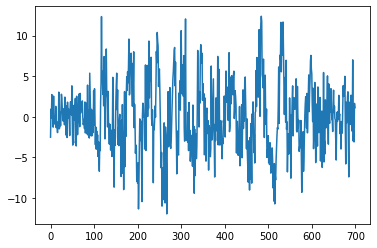

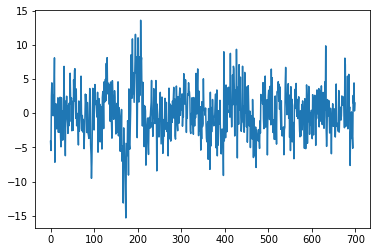

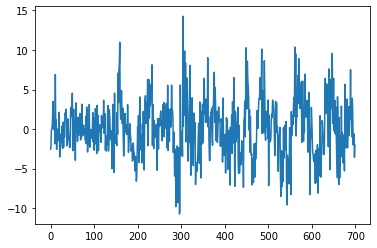

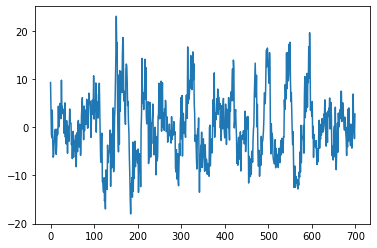

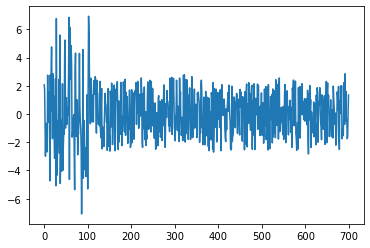

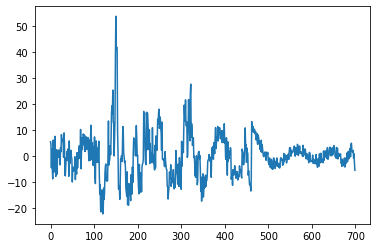

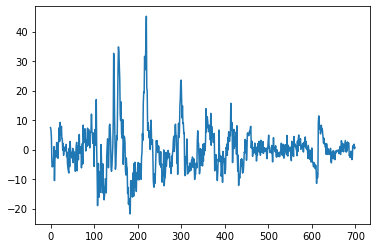

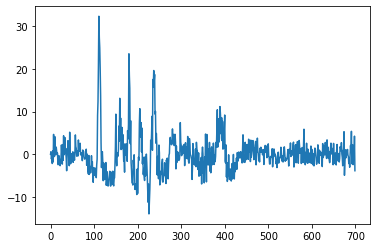

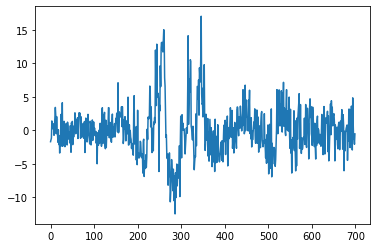

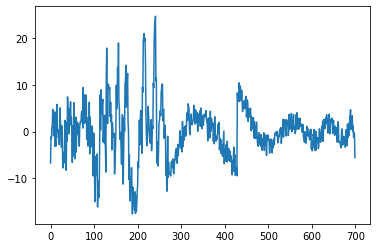

In [47]:
for i in range(len(nematocytes[0:5])):
    plt.plot(nematocytes[i])
    plt.show()

for neurons in filt_neurons[0:5]:
    plt.plot(neurons)
    plt.show()

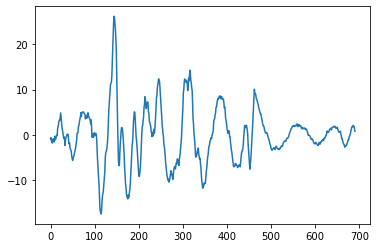

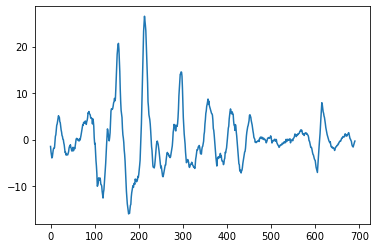

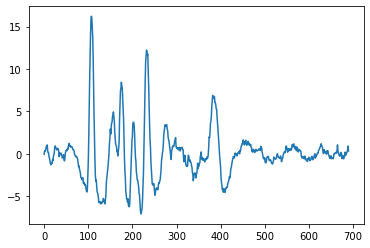

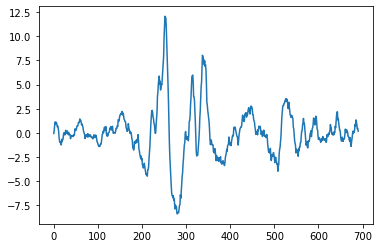

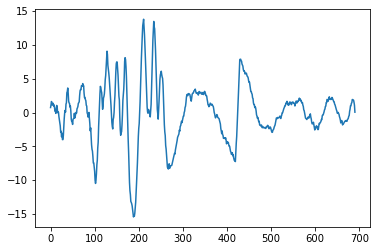

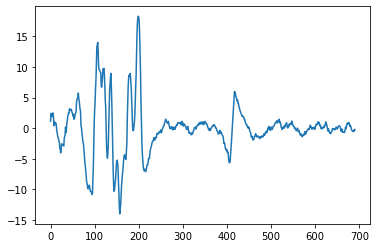

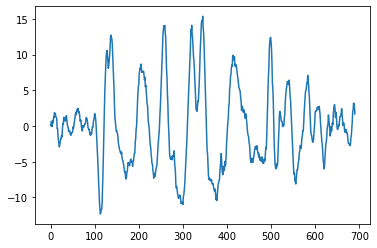

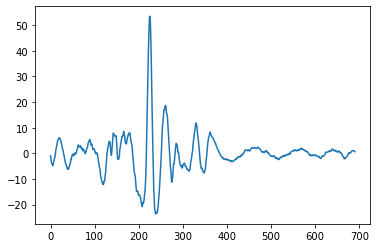

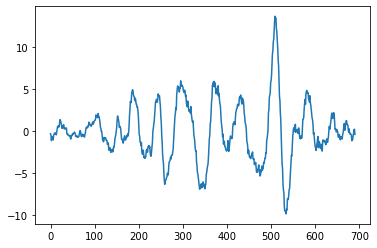

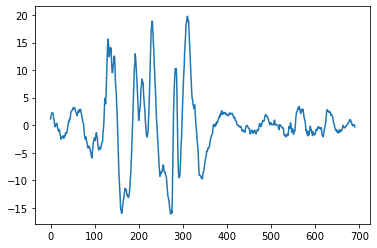

In [48]:
#smooth the data?
smoothdata = hy.smoother(filt_neurons, 10)

for smooth in smoothdata[0:10]:
    plt.plot(smooth)
    plt.show()

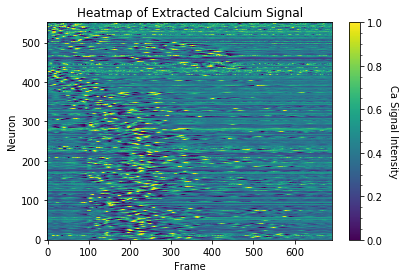

In [49]:
#Plot Heatmap of Calcium Signal
#can normalise here for better signal...

filt_neurons = smoothdata
hy.plot_heatmap(hy.norm_all_data(filt_neurons), 'Heatmap of Extracted Calcium Signal', 'Ca Signal Intensity')

Calcium Signal Extraction - Optional Cells
--------------------------
**These Cells Dont Need to be Run**          
Cells for evaluating performance or saving preliminary results        
Only Run the Cells you want to

**Optional Cells to Evaluate ROI Tracking**      
Input frame number to view all of the ROIs tracked in that frame      

In [50]:
# #superimpose ROIs on video frame in both channels

# #select frame to view
# frame_to_view = 510

# hy.Super_impose(vid, frame_to_view, posit_corrected1, 'Neuron Tracking in Green Channel')
# hy.Super_impose(red_vid, frame_to_view, posit_corrected1, 'Neuron Tracking in Red Channel')

**Optional Cells to Evaluate Effect and Correction of Motion Artifacts and Red Leakage**

In [51]:
#Plot Raw Transients in Green - uncomment to use!

# hy.plot_all(intensities1)

In [52]:
# #Plot Red Transient to check for motion artefacts and leaking
# Neuron_with_possible_artefact = 7

# plt.figure(1)
# plt.title('Raw Red Channel Plot')
# plt.plot(intensities_red[Neuron_with_possible_artefact])
# plt.show()

# #After Correction:
# plt.figure(2)
# plt.plot(CaSignal[Neuron_with_possible_artefact])
# plt.title('Calcium Signal Plot')
# plt.show()

**Optional Cell to Evaluate Activity and Tracking of Individual Neurons**     
Allows comparison between intensity trace of a neuron and that neuron's ROI at a particular frame    
Input Neuron Number and Frame Number

In [53]:
# #input neuron to check
# neuron = 7

# #input frame form video to view the ROI
# eval_frame = 300

# hy.full_eval(neuron, CaSignal, eval_frame, dim, posit_corrected, vid)

FILTERING & SMOOTHING
-----------------------

The following cells will filter the intensity traces of the neurons to remove signal that are likely from nematocytes, smooth the results to reduce the appearance of noise, and detrend the resulting data

In [54]:
# #Detrending data - use on filtered or smoothed data

# #Set Polynomial Degree
# poly_deg = 17

# detrended = hy.detrend_all(CaSignal, poly_deg)

In [55]:
# #Filter Nematocytes - Filtering performed via evaluating fit with a Gaussian distribution

# alpha = 1e-6 #Tune threshold for coherence to gaussian distribution - need to use detrended data with this function
# detrended2, posit_corrected2, removed = hy.Gaussian_noise_filter(detrended, alpha, posit_corrected1)

In [56]:
# #evaluate filtering of neurons

# hy.plot_all(removed)

In [57]:
# #Display Filtering and Smoothing Results

# #Display Total Number of Neurons After Filtering
# print('no of neurons: ', len(detrended))

# plt.figure(3)
# for i in range(len(detrended2)):
#     plt.plot(detrended2[i])
# plt.title('Detrended Calcium Signal Data')
# plt.xlabel('Frame')
# plt.ylabel('Calcium Signal Detrended')
# plt.show()

# hy.plot_heatmap(hy.norm_all_data(detrended2), 'Heatmap of Filtered Detrended Data', 'Calcium Signal Intensity')

In [58]:
#Plot all remaining neurons after filtering and processing - uncomment to use

# hy.plot_all(detrended2)

CALCIUM SIGNAL ANALYSIS
-------------------------------------

The following cells analyse the results to show extract spikes from the Calcium intensity data

**Tune Threshold used to Indentify Spikes to Fit Data Using Evaluation Cell for FOOPSI at End of Script**

In [59]:
#Create Raster Plot using CAIMAN's FOOPSI function - Denoising and Deconvolution

#foopsi
Foopsi_ca, spikes_signal_dR = hy.FOOPSI_all(filt_neurons)

#Extract Raster Plot Data

#Threshold (could use a theoretical value for threshold! - See CAIMAN Docs - but trial & error is also fine)
#USE FOOPSI EVALUATION CELL TO TUNE THIS PARAMETER (0.04 works well)
spike_thresh_dR = 0.2

raster_array_dR = hy.Find_Raster_adaptive(spikes_signal_dR, spike_thresh_dR)

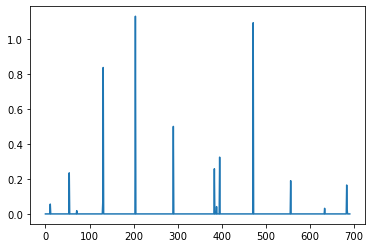

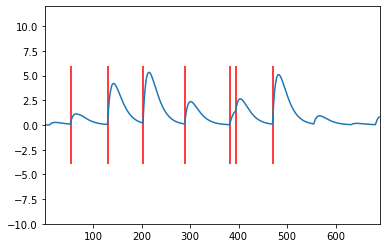

[ 54. 131. 204. 290. 383. 395. 471.]


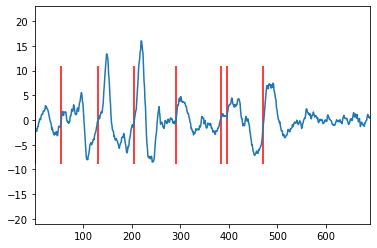

In [88]:
i = 10

plt.plot(spikes_signal_dR[i])
plt.show()
plt.plot(Foopsi_ca[i])
# plt.show()

plt.eventplot(raster_array_dR[i], linelengths =10, colors = 'red')
plt.xlim((1, len(raster_array_dR[i])))
plt.show()

spikelocs = np.where(raster_array_dR[i] > 0)
print(raster_array_dR[i][spikelocs])

plt.plot(filt_neurons[i])
plt.eventplot(raster_array_dR[i], linelengths =20, colors = 'red')
plt.xlim((1, len(raster_array_dR[i])))
plt.show()




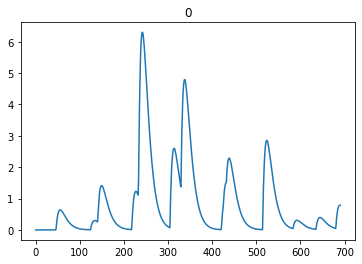

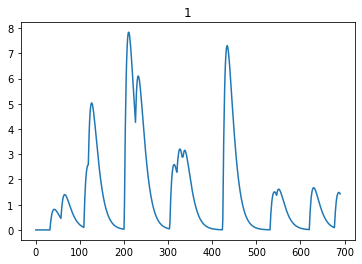

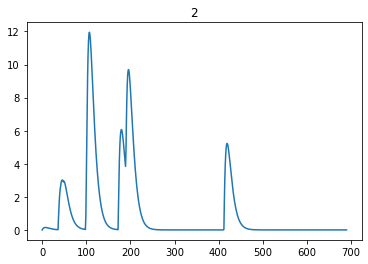

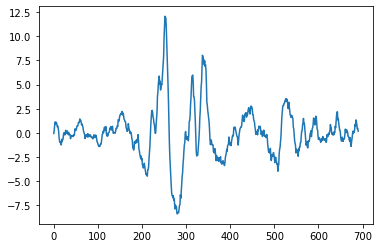

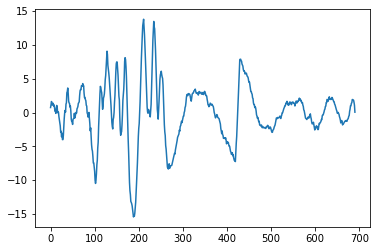

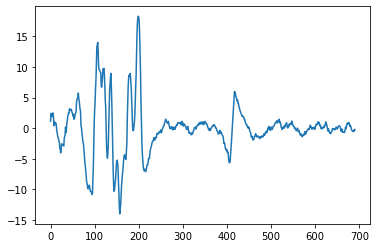

In [61]:
#Plot all denoised calcium traces - uncomment to use!

hy.plot_all(Foopsi_ca[3:6])

for neurons in filt_neurons[3:6]:
    plt.plot(neurons)
    plt.show()

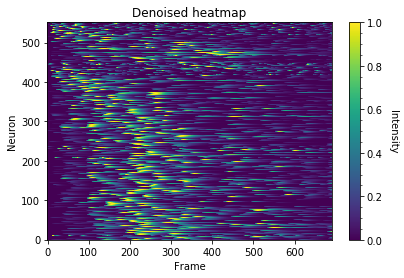

In [62]:
hy.plot_heatmap(hy.norm_all_data(Foopsi_ca), 'Denoised heatmap', 'Intensity')

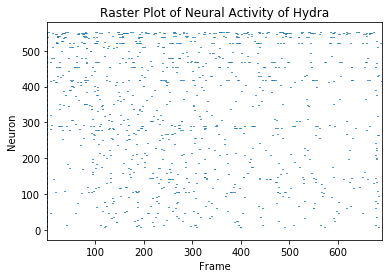

In [63]:
#Display Results

#plot raster
#zero values from way array was made array give large syncronous train at start of the signal - should fix (.append method?)
plt.figure(2)
plt.eventplot(raster_array_dR,linelengths = 0.6)
plt.ylabel('Neuron')
plt.xlabel('Frame')
plt.title('Raster Plot of Neural Activity of Hydra')
plt.xlim((1,len(raster_array_dR[0])))
plt.show()

In [64]:
#plot rasterplot for all neurons - uncomment to use!

# for i in range(len(raster_array_dR)):
#     plt.eventplot(raster_array_dR[i],linelengths = 0.6)
#     plt.xlim((1,len(raster_array_dR[0])))
#     plt.title(i)
#     plt.show()

BEHAVIOUR ANALYSIS WITH NEURAL ACTIVITY
---------------------------------------------
These cells plot neural activity and behaviour together to allow comparision between neural activity and behaviour     
Most of this step still needs to be done by hand unfortunately...

In [65]:
#Input Behaviour Arrays

#behaviour array: [frame behaviour turns on,frame off,on,off,on,... etc]
behaviour_frames = [0,212,605,len(detrended[0])]

#fill with numbered behaviourws in order they occur
behaviours = [1,0,1]

#fill with colours corresponding to numbered behaviours
colours=['blue','green']

NameError: name 'detrended' is not defined

In [ ]:
#Display Neural Activity with Behaviour

plt.figure(1)
fig, ax = plt.subplots()
ax.margins(0.02)
for behav in range(len(behaviour_frames)-1):
    colour_face = colours[behaviours[behav]]
    ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face, alpha = 0.2)
for i in range(len(intensities1)):
    plt.plot(intensities1[i])
plt.title('Raw Intensities plotted with CB and RP behaviour (CB=green)')
plt.xlabel('Frame')
plt.ylabel('Intensity')
plt.show()

plt.figure(2)
fig, ax = plt.subplots()
ax.margins(0.02)
for behav in range(len(behaviour_frames)-1):
    colour_face = colours[behaviours[behav]]
    ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face, alpha = 0.2)
for i in range(len(detrended2)):
    plt.plot(detrended2[i])
plt.title('Processed Intensities plotted with CB and RP behaviour (CB=green)')
plt.xlabel('Frame')
plt.ylabel('Calcium Signal Intensities Detrended')
plt.show()

plt.figure(3)
fig, ax = plt.subplots()
ax.margins(0.02)
for behav in range(len(behaviour_frames)-1):
    colour_face = colours[behaviours[behav]]
    ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face,alpha = 0.2)
plt.eventplot(raster_array_dR,linelengths = 0.6)
plt.xlim((1,len(raster_array_dR[0])))
plt.ylabel('Neuron')
plt.xlabel('Frame')
plt.title('Raster Plot of Neural Activity of Hydra Plotted with Behaviour')
plt.show()

CORRELATION AND INTERPRETATION OF DATA
-----------------------------------
The following cells work to group neurons together into ensembles, display various froms of correlation data presentation, and correlate each neuron to different types of behaviour

**Input Correlation Threshold to be Used to Group Neurons**

In [ ]:
#Create Dendogram (can change method between ward, average, etc)
CaSignal_norm = spikes_signal_dR
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(CaSignal_norm, method='ward'))

**Input Number of Clusters Based on Results from Dendogram**

In [ ]:
#extract and view neurons from each cluster 

#number of clusters chosen from examination of dendogram
number_of_clusters = 5

clusters = hy.give_cluster_assigns(pd.DataFrame(CaSignal_norm), number_of_clusters, transpose=False)
clusters = clusters.values

#plot specific cluster's neurons traces

cluster_to_view = 1

for i in range(len(clusters)):
    if clusters[i] == cluster_to_view:
        plt.figure(i-1)
        plt.title(i)
        plt.plot(Foopsi_ca[i])
        plt.show()

In [ ]:
#Super impose locations of neurons in specified Cluster onto video frame

cluster_to_view = 1
frame_for_cluster = 300
video_for_cluster = vid
title_for_cluster = 'Cluster Positions'

hy.Super_impose_cluster(video = video_for_cluster, frame_to_view = frame_for_cluster, posit_corrected = posit_corrected, clusters = clusters, cluster_to_view = cluster_to_view, Title = title_for_cluster)

In [ ]:
#ClusterMap
#change figure size to see all labels if necessary

df = pd.DataFrame(np.transpose(CaSignal_norm))

# Draw the full plot
sns.clustermap(df.corr(), center=0, cmap="coolwarm",linewidths=.75, figsize=(19, 19), method = 'ward')

In [ ]:
#Investigate Correlations from ClusterMap

#input neurons to view
neuron_1 = 7
neuron_2 = 14

plt.figure(1)
fig, ax = plt.subplots()
ax.margins(0.02)
for behav in range(len(behaviour_frames)-1):
    colour_face = colours[behaviours[behav]]
    ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face,alpha = 0.2)
plt.plot(detrended2[neuron_1])
plt.plot(detrended2[neuron_2])
plt.show()

plt.figure(2)
plt.title(neuron_1)
plt.eventplot(raster_array_dR[neuron_1],linelengths = 0.6)
plt.xlim((1,len(raster_array_dR[0])))
plt.show()

plt.figure(3)
plt.title(neuron_2)
plt.eventplot(raster_array_dR[neuron_2],linelengths = 0.6)
plt.xlim((1,len(raster_array_dR[0])))
plt.show()

In [ ]:
#Single neuron investigation

neuron_to_investigate = 7
frame_to_investigate = 200

hy.single_neuron_investigation(neuron_to_investigate, intensities1, Foopsi_ca, raster_array_dR, vid, frame_to_investigate, dim, posit_corrected2)

**Save Data**
===============
**Optional Cells to Save Results**        
Run these cells to save the data as a .csv         
Input file name and path where file should be saved           
**On Windows: Paths still need to start with 'r'**              
e.g. r'C:\Users\rylab\Documents\path to your folder\title.csv'

**Save Raw GCamp Intensity Data**

In [ ]:
#Save Raw GCamp Intensity data as a .csv 

# Save_Path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_intensity_behaviour_longclip.csv'

# intensity_dataframe = pd.DataFrame(intensities)
# intensity_dataframe.to_csv(Save_Path)

**Save CaSignal Intensity Data**

In [ ]:
#save CaSignal data to .csv

# Ca_save_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_CaSig.csv'

# intensity_dataframe = pd.DataFrame(CaSignal)
# intensity_dataframe.to_csv(Ca_save_path)

**Sava Detrended Intensity Data**

In [ ]:
#save detrended data to .csv

# dR_detrend_save_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_detrend.csv'

# dfintensity_dataframe = pd.DataFrame(detrended)
# dfintensity_dataframe.to_csv(dR_detrend_save_path)

**Save Foopsi De-noised Data**

In [ ]:
# #save Foopsi de-noised data to .csv

# Ca_denoised_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\Project_Behaviour_and_Neural_Activity\Single_Cell_Analysis_Neural\Single_Cell_Data\VID1_oct_4_3hz\Results\denoised_neuraldata.csv'

# ca_dataframe = pd.DataFrame(Foopsi_ca)
# ca_dataframe.to_csv(Ca_denoised_path)

**Save Raster Plot Data**

In [ ]:
#save raster data to .csv (needs to be reformatted from event plot form first)

# raster_save_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_rasterb1.csv'

# raster_array_pred = np.zeros((len(raster_array_dR),len(raster_array_dR[1])))
# for i in range(len(spikes_signal_dR)):
#     for j in range(len(spikes_signal_dR[i])):
#         if max(spikes_signal_dR[i]) > 0:
#             if spikes_signal_dR[i][j] >= spike_thresh_dR: #*np.mean(spikes_signal_dR[i]):
#                 raster_array_pred[i][j] = 1

# raster_dataframe = pd.DataFrame(raster_array_pred)
# raster_dataframe.to_csv(raster_save_path)

**Save Behaviour Data**

In [ ]:
#Save Behaviour Array tp .csv
# behaviour_Save_Path = r"C:\Users\rylab\Downloads\behav_array.csv"

# behav_array = np.zeros(len(vid))
# for i in range(len(behaviours)):
#     behav_array[behaviour_frames[i]:behaviour_frames[i+1]] = behaviours[i]
    
# behaviour_dataframe = pd.DataFrame(behav_array)
# behaviour_dataframe.to_csv(behaviour_Save_Path)

**Evaluation Cells**
====================
These cells allow for the evaluation of the tuning of various functions

**Evaluate Polynomial Detrending Parameters** 

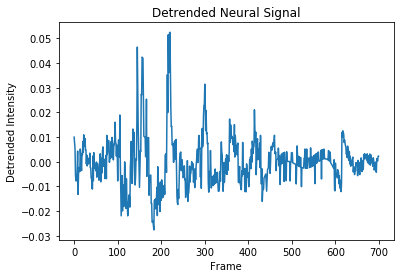

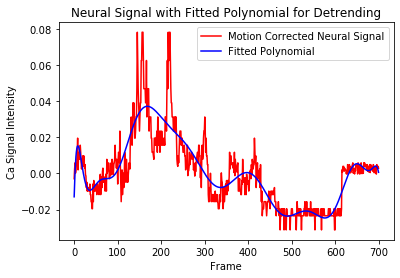

In [ ]:
#evaluate ploynomail detrending
neuron_test_detrend = 1
#polynomial degree of 15-17 gives good results - but tune for new data!
polynomial_test_degree  = 17
detrend_one = hy.detrend(CaSignal[neuron_test_detrend],polynomial_test_degree)

x_vals = np.arange(len(CaSignal[neuron_test_detrend]))
coeffs = np.polyfit(x_vals, CaSignal[neuron_test_detrend], polynomial_test_degree)
polynomial = np.polyval(coeffs, x_vals)

plt.figure(1)
plt.plot(detrend_one)
plt.xlabel('Frame')
plt.ylabel('Detrended Intensity')
plt.title('Detrended Neural Signal')
plt.show()
plt.plot(CaSignal[neuron_test_detrend], c = 'r')
plt.plot(polynomial, c = 'b')
plt.xlabel('Frame')
plt.ylabel('Ca Signal Intensity')
plt.title('Neural Signal with Fitted Polynomial for Detrending')
plt.legend(['Motion Corrected Neural Signal', 'Fitted Polynomial'])
plt.show()

**Evaluste ICA vs Ratiometric Artefact Removal**

In [ ]:
# New ICA vs Ratiometric

ica_test_neuron = 7

a, b = np.asanyarray(hy.norm_Data(intensities1[ica_test_neuron])), np.asanyarray(hy.norm_Data(intensities_red[ica_test_neuron]))
plt.plot(a, c = 'g')
plt.title('Raw Intensities of GCaMP7 (Green) Channel')
plt.xlabel('Frames')
plt.ylabel('Normalised Intensity')
plt.show()
plt.plot(b, c = 'r')
plt.title('Raw Intensities of tdTomato (Red) Channel')
plt.xlabel('Frames')
plt.ylabel('Normalised Intensity')
plt.show()

c = (a+1)/(b+1)
plt.plot(c)
plt.title('Ratiometric Correction of Motion Artefacts')
plt.xlabel('Frames')
plt.ylabel('Intensity Ratio')
plt.show()

print(min(a))
print(min(b))

ica_g = hy.ICAdecorr([a],[b],0.05, 10)
plt.plot(ica_g[0])
plt.title('ICA Correction of Motion Artefacts')
plt.xlabel('Frames')
plt.ylabel('Normalised Intensity')
# plt.show()
# plot_all(p)
# print(c)

**Evaluate FOOPSI Parameters**

In [ ]:
#Tuning for FOOPSI 

tuning_thresh_foopsi = 0.03

evaluation_neuron_foopsi = 0
spikes_signal_tuning = hy.FOOPSI_all(hy.normalize(detrended))

plt.figure(1)
plt.plot(detrended[evaluation_neuron_foopsi])
plt.title('detrended signal for Specified Neuron')
plt.ylabel('Calcium Signal Detrended Intensity')
plt.xlabel('Frame Number')
plt.show()

plt.figure(2)
plt.plot(spikes_signal_dR[evaluation_neuron_foopsi])
plt.title('FOOPSI Results for Specified Neuron')
plt.ylabel('Estimated Neural Activity')
plt.xlabel('Frame Number')
plt.show()

NameError: name 'detrended' is not defined

**Evaluate Raster Reshaping**

In [ ]:
# #Evaluate Raster Reshaping step for saving as csv

# raster_reshape_test_neuron = 5

# plt.plot(raster_array_pred[raster_reshape_test_neuron], color = 'r')
# plt.eventplot(raster_array_dR[raster_reshape_test_neuron])

**Evaluate Neuron Tracking**

In [ ]:
# n = 22
# _,_,_,display = hy.SingleCellIntensity(neuron = n, video = vid, positions = posit_corrected, dimentionROI = dim, Circle_radius = 4, distance_threshold = 4, display_on = True)


**Save Tracked Neurons**

In [ ]:
# for i in range(len(display)):
#     plt.imshow(display[i])
#     title = 'neuron_' + str(i) + '.tif'
#     plt.savefig(str(title), format = 'tif')